<a href="https://colab.research.google.com/github/LinOna/agroforestry/blob/main/notebooks/Q3_analyses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Q3 — PWP tracking (Colab-ready)
import os, glob, re, json, io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Repro & style
RANDOM_SEED = 123
np.random.seed(RANDOM_SEED)
plt.rcParams["figure.figsize"] = (7.5, 5)
plt.rcParams["figure.dpi"] = 150

# I/O
FIG_DIR = "q3_figs"
OUT_DIR = "q3_pwp"
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)

# Colors (AF gradient)
COLOR_L = "#1f77b4"  # Left
COLOR_R = "#ff7f0e"  # Right
COLOR_C = "#7f7f7f"  # Center
DIST_ORDER = [1.0, 4.0, 8.0, 16.5]

def to_dt_utc(x):
    return pd.to_datetime(x, errors="coerce", utc=True)

def _pick_latest(paths):
    paths = [p for p in paths if os.path.isfile(p)]
    return max(paths, key=os.path.getmtime) if paths else None

# --- Upload or discover CSV ---
CSV_PATH = None  # leave None to discover or upload
if CSV_PATH is None:
    # Try discover
    patterns = [
        "analysis_ready_v*.csv",
        "af_clean_v01/analysis_ready_v*.csv",
        "**/analysis_ready_v*.csv",
    ]
    hits = []
    for pat in patterns:
        hits.extend(glob.glob(pat, recursive=True))
    CSV_PATH = _pick_latest(hits)

if CSV_PATH is None:
    # Colab manual upload
    try:
        from google.colab import files
        print("Upload your analysis_ready_vXXX.csv …")
        uploaded = files.upload()
        CSV_PATH = list(uploaded.keys())[0] if uploaded else None
    except Exception:
        CSV_PATH = None

assert CSV_PATH, "No CSV found/uploaded. Set CSV_PATH to your analysis_ready_v*.csv."
print("Using CSV:", CSV_PATH)


Using CSV: analysis_ready_v006.csv


In [2]:
# Load
df = pd.read_csv(CSV_PATH, low_memory=False)

# Timestamp -> _ts (UTC) and _date (day)
COL_TS = "timestamp" if "timestamp" in df.columns else (
         "timestamp_iso" if "timestamp_iso" in df.columns else (
         "ts_ns" if "ts_ns" in df.columns else None))
assert COL_TS is not None, "Need a timestamp/timestamp_iso/ts_ns column."

if COL_TS == "ts_ns":
    df["_ts"] = pd.to_datetime(df["ts_ns"].astype("int64"), utc=True, errors="coerce")
else:
    df["_ts"] = to_dt_utc(df[COL_TS])
df["_date"] = df["_ts"].dt.tz_convert("UTC").dt.floor("D") if df["_ts"].dt.tz is not None else pd.to_datetime(df["_ts"]).dt.floor("D")

NODE_COL = "node" if "node" in df.columns else ("node_id" if "node_id" in df.columns else None)
SITE_COL = "station_type" if "station_type" in df.columns else ("site" if "site" in df.columns else None)
assert NODE_COL and SITE_COL, "Need node/node_id and station_type/site."

def choose_first(*cols):
    for c in cols:
        if c in df.columns: return c
    return None

var_map = {
    "air_temp":        choose_first("temperature__pref","temperature"),
    "rh":              choose_first("humidity__pref","humidity"),
    "rad":             choose_first("global_radiation__pref","global_radiation_clean","global_radiation"),
    "wind":            choose_first("wind_speed_mean__pref","wind_speed_mean_clean","wind_speed_mean"),
    "soil_moisture_0": choose_first("ground_humidity_0__pref","ground_humidity_0_clean","ground_humidity_0"),
    "soil_moisture_1": choose_first("ground_humidity_1__pref","ground_humidity_1_clean","ground_humidity_1"),
    "soil_temp_0":     choose_first("ground_temp_0__pref","ground_temp_0_clean","ground_temp_0"),
    "soil_temp_1":     choose_first("ground_temp_1__pref","ground_temp_1_clean","ground_temp_1"),
}
print("[var_map]", {k:v for k,v in var_map.items() if v})

# AF-only
af = df[df[SITE_COL].astype(str).str.lower().eq("agroforestry")].copy()
if "node" not in af.columns and "node_id" in af.columns:
    af.rename(columns={"node_id":"node"}, inplace=True)

# Distances & side
NODE_DISTANCE_M = {
    "node_182": 1.0,  "node_187": 4.0,  "node_179": 8.0,
    "node_183":16.5,  "node_181": 8.0,  "node_186": 4.0, "node_184": 1.0,
}
SIDE_MAP = {
    "node_182":"L","node_187":"L","node_179":"L",
    "node_183":"C",
    "node_181":"R","node_186":"R","node_184":"R",
}

def _norm_node(x):
    s = str(x)
    return s if s.startswith("node_") else f"node_{s}"

af["node_key"] = af["node"].astype(str).map(_norm_node)
af["distance_m"] = af["node_key"].map(NODE_DISTANCE_M).astype("float64")
af["side"] = af["node_key"].map(SIDE_MAP).astype("category")

# Soil composites (node-level row mean)
def _rowmean(frame, cols):
    cols = [c for c in cols if c and c in frame.columns]
    if not cols: return np.full(len(frame), np.nan)
    arr = np.vstack([pd.to_numeric(frame[c], errors="coerce").to_numpy() for c in cols])
    return np.nanmean(arr, axis=0)

af["soil_moisture__comp"] = _rowmean(af, [var_map.get("soil_moisture_0"), var_map.get("soil_moisture_1")])
af["soil_temp__comp"]     = _rowmean(af, [var_map.get("soil_temp_0"), var_map.get("soil_temp_1")])

# Keep only what we need going forward
keep_cols = ["_date","node_key","distance_m","side","soil_moisture__comp"]
af = af[keep_cols].copy()
for c in ["distance_m","soil_moisture__comp"]:
    af[c] = pd.to_numeric(af[c], errors="coerce")
print(af.head())


[var_map] {'air_temp': 'temperature__pref', 'rh': 'humidity__pref', 'rad': 'global_radiation__pref', 'wind': 'wind_speed_mean__pref', 'soil_moisture_0': 'ground_humidity_0__pref', 'soil_moisture_1': 'ground_humidity_1__pref', 'soil_temp_0': 'ground_temp_0__pref', 'soil_temp_1': 'ground_temp_1__pref'}
                          _date  node_key  distance_m side  \
44962 2023-10-30 00:00:00+00:00  node_179         8.0    L   
44963 2023-10-30 00:00:00+00:00  node_179         8.0    L   
44964 2023-10-30 00:00:00+00:00  node_179         8.0    L   
44965 2023-10-30 00:00:00+00:00  node_179         8.0    L   
44966 2023-10-30 00:00:00+00:00  node_179         8.0    L   

       soil_moisture__comp  
44962                6.480  
44963                6.640  
44964                6.435  
44965                6.555  
44966                6.560  


/tmp/ipython-input-2652317759.py:66: RuntimeWarning: Mean of empty slice
  return np.nanmean(arr, axis=0)
/tmp/ipython-input-2652317759.py:66: RuntimeWarning: Mean of empty slice
  return np.nanmean(arr, axis=0)


In [3]:
# Node-equal: mean per day × node
daily_node = (
    af.groupby(["_date","node_key","distance_m","side"], observed=True, as_index=False)
      .mean(numeric_only=True)
      .sort_values(["_date","distance_m","node_key"])
)

# Month & season
daily_node["month"]  = pd.to_datetime(daily_node["_date"]).dt.month
daily_node["season"] = daily_node["month"].map({12:"DJF",1:"DJF",2:"DJF",
                                                3:"MAM",4:"MAM",5:"MAM",
                                                6:"JJA",7:"JJA",8:"JJA",
                                                9:"SON",10:"SON",11:"SON"})
# Save for provenance
daily_node.to_csv(os.path.join(OUT_DIR, "q3_daily_by_node.csv"), index=False)
print("daily_node:", daily_node.shape, "saved →", os.path.join(OUT_DIR, "q3_daily_by_node.csv"))


daily_node: (4201, 7) saved → q3_pwp/q3_daily_by_node.csv


In [4]:
# ==== PWP configuration ====
# If one value for all nodes:
PWP = 10.0   # percent VWC example; adjust to your threshold

# Or uncomment to specify per-node thresholds (overrides PWP for those keys)
# PWP_BY_NODE = {"node_182": 11.0, "node_187": 10.5, "node_179": 10.0,
#                "node_183": 9.5,  "node_181": 10.0, "node_186": 10.5, "node_184": 11.0}
PWP_BY_NODE = {}  # keep empty unless you want node-specific thresholds

def _threshold_for(node_key):
    return float(PWP_BY_NODE.get(node_key, PWP))

d = daily_node.copy()
d["pwp_thresh"] = d["node_key"].map(_threshold_for).astype(float)
d["below_pwp"]  = (pd.to_numeric(d["soil_moisture__comp"], errors="coerce") < d["pwp_thresh"]).astype(float)
print(d[["soil_moisture__comp","pwp_thresh","below_pwp"]].head())


   soil_moisture__comp  pwp_thresh  below_pwp
2             5.362935        10.0        1.0
4             6.673043        10.0        1.0
5             5.180652        10.0        1.0
0             6.468261        10.0        1.0
1             8.744239        10.0        1.0


In [5]:
# Share of days below PWP by distance & side (overall and by month)
per_day = (d.groupby(["_date","side","distance_m"], observed=True)["below_pwp"]
             .mean().reset_index(name="p_below"))

# Overall by distance & side
risk_overall = (per_day.groupby(["side","distance_m"], observed=True)["p_below"]
                      .mean().reset_index())
risk_overall["kind"] = "overall"

# Monthly by distance & side
per_day["month"] = pd.to_datetime(per_day["_date"]).dt.month
risk_monthly = (per_day.groupby(["month","side","distance_m"], observed=True)["p_below"]
                      .mean().reset_index())
risk_monthly["kind"] = "by_month"

risk_all = pd.concat([risk_overall, risk_monthly], ignore_index=True)
risk_path = os.path.join(OUT_DIR, "pwp_risk_by_distance.csv")
risk_all.to_csv(risk_path, index=False)
print("Saved:", risk_path)

# Longest consecutive run below PWP per node
def longest_run(series):
    # expects 0/1 float series ordered by date
    x = series.fillna(0).astype(int).to_numpy()
    if x.size == 0: return 0
    max_run = run = 0
    for v in x:
        if v == 1:
            run += 1; max_run = max(max_run, run)
        else:
            run = 0
    return int(max_run)

runs = (d.sort_values(["node_key","_date"])
         .groupby("node_key", observed=True)["below_pwp"]
         .apply(longest_run)
         .reset_index(name="longest_run_days"))

runs["distance_m"] = runs["node_key"].map({"node_182":1.0,"node_187":4.0,"node_179":8.0,
                                           "node_183":16.5,"node_181":8.0,"node_186":4.0,"node_184":1.0})
runs["side"] = runs["node_key"].map({"node_182":"L","node_187":"L","node_179":"L",
                                     "node_183":"C","node_181":"R","node_186":"R","node_184":"R"})
runs_path = os.path.join(OUT_DIR, "pwp_runlengths_by_node.csv")
runs.to_csv(runs_path, index=False)
print("Saved:", runs_path)


Saved: q3_pwp/pwp_risk_by_distance.csv
Saved: q3_pwp/pwp_runlengths_by_node.csv


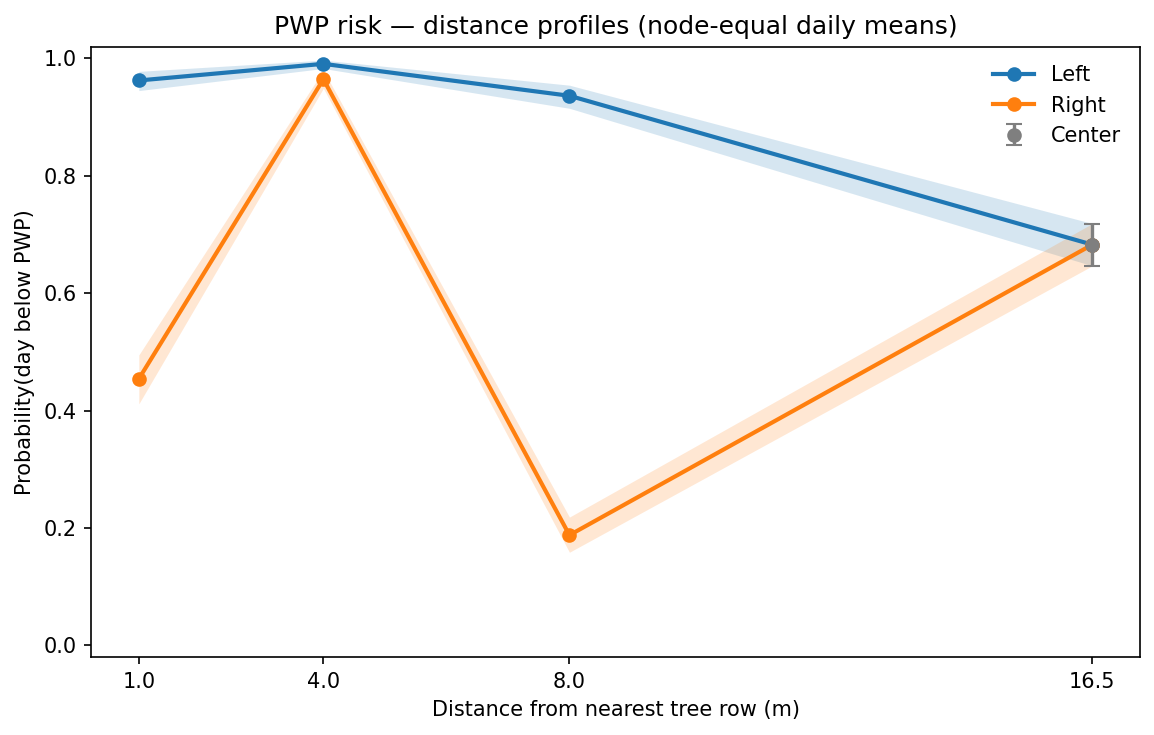

Saved: q3_figs/pwp_distance_profiles.png | q3_figs/pwp_distance_profiles.pdf


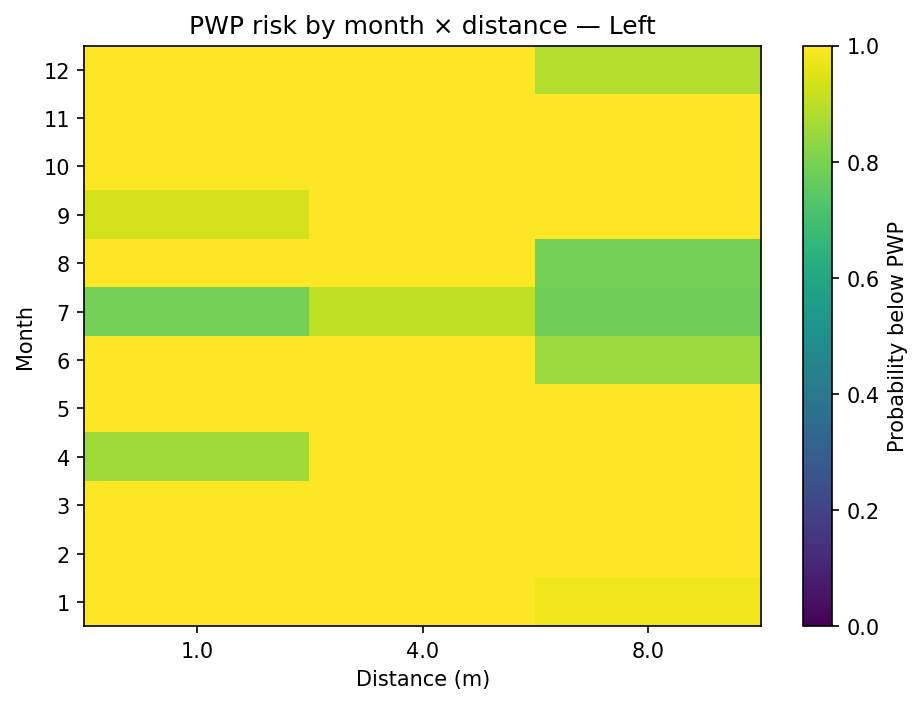

Saved: q3_figs/pwp_heatmap_L.png | q3_figs/pwp_heatmap_L.pdf


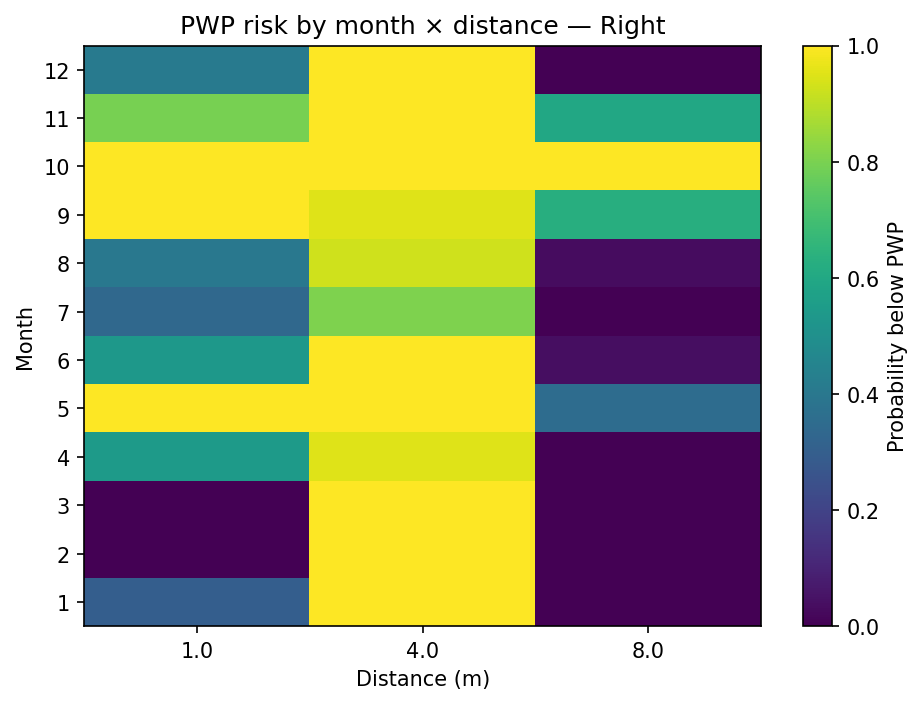

Saved: q3_figs/pwp_heatmap_R.png | q3_figs/pwp_heatmap_R.pdf


In [6]:
from matplotlib.ticker import MaxNLocator

def _bootstrap_mean_ci(vals, B=2000, seed=RANDOM_SEED, q=(2.5,97.5)):
    v = pd.to_numeric(pd.Series(vals), errors="coerce").to_numpy(float)
    v = v[np.isfinite(v)]
    if v.size == 0: return (np.nan, np.nan, np.nan)
    rng = np.random.default_rng(seed)
    idx = rng.integers(0, v.size, size=(B, v.size))
    m = v[idx].mean(axis=1)
    lo, hi = np.percentile(m, list(q))
    return float(v.mean()), float(lo), float(hi)

# A) Distance profiles of probability(below PWP), per side, 1→4→8→16.5 (center appended)
def plot_pwp_distance_profiles(per_day):
    rows=[]
    # Center stats at 16.5 to append to each side
    cen = per_day[(np.isclose(per_day["distance_m"],16.5)) & (per_day["side"].eq("C"))]
    c_mu=c_lo=c_hi=np.nan
    if len(cen):
        c_mu,c_lo,c_hi = _bootstrap_mean_ci(cen["p_below"])
    for side in ["L","R"]:
        g = per_day[per_day["side"]==side]
        for dist in [1.0, 4.0, 8.0]:
            gg = g[np.isclose(g["distance_m"], dist)]
            if len(gg):
                mu, lo, hi = _bootstrap_mean_ci(gg["p_below"])
                rows.append((side, dist, mu, lo, hi))
        if np.isfinite(c_mu):
            rows.append((side, 16.5, c_mu, c_lo, c_hi))
    agg = pd.DataFrame(rows, columns=["side","distance_m","mean","lo","hi"])
    if agg.empty:
        print("[profiles] No data to plot."); return

    plt.figure(figsize=(7.8,5.0))
    for side,color in [("L",COLOR_L),("R",COLOR_R)]:
        g = agg[agg["side"]==side].copy()
        g["distance_m"] = pd.Categorical(g["distance_m"], categories=DIST_ORDER, ordered=True)
        g = g.sort_values("distance_m")
        x = g["distance_m"].astype(float).values
        plt.plot(x, g["mean"], marker="o", lw=2, color=color, label=("Left" if side=="L" else "Right"))
        plt.fill_between(x, g["lo"], g["hi"], color=color, alpha=0.18, linewidth=0)
    # center marker
    if np.isfinite(c_mu):
        plt.errorbar([16.5],[c_mu], yerr=[[c_mu-c_lo],[c_hi-c_mu]],
                     fmt="o", color=COLOR_C, ecolor=COLOR_C, capsize=4, lw=1.6, label="Center")

    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.xticks(DIST_ORDER, [str(d) for d in DIST_ORDER])
    plt.ylim(-0.02, 1.02)
    plt.ylabel("Probability(day below PWP)")
    plt.xlabel("Distance from nearest tree row (m)")
    plt.title("PWP risk — distance profiles (node-equal daily means)")
    plt.legend(frameon=False)
    plt.tight_layout()
    base = os.path.join(FIG_DIR, "pwp_distance_profiles")
    plt.savefig(base+".png", dpi=300); plt.savefig(base+".pdf"); plt.show()
    print("Saved:", base+".png", "|", base+".pdf")

# B) Heatmaps: month × distance risk per side
def plot_pwp_heatmaps(per_day):
    M = (per_day.assign(month=lambda x: pd.to_datetime(x["_date"]).dt.month)
                .groupby(["month","side","distance_m"], observed=True)["p_below"]
                .mean().reset_index())
    for side in ["L","R"]:
        g = M[M["side"]==side].copy()
        if g.empty:
            print(f"[heatmap] No data for side {side}");
            continue
        piv = g.pivot(index="month", columns="distance_m", values="p_below")
        cols = [d for d in DIST_ORDER if d in piv.columns]
        piv = piv.reindex(columns=cols)
        plt.figure(figsize=(6.4,4.8))
        im = plt.imshow(piv.values, aspect="auto", origin="lower", vmin=0, vmax=1)
        plt.xticks(np.arange(len(cols)), [str(c) for c in cols])
        plt.yticks(np.arange(1,13)-1, [str(m) for m in range(1,13)])
        plt.xlabel("Distance (m)"); plt.ylabel("Month")
        plt.title(f"PWP risk by month × distance — {'Left' if side=='L' else 'Right'}")
        cb = plt.colorbar(im); cb.ax.set_ylabel("Probability below PWP")
        plt.tight_layout()
        base = os.path.join(FIG_DIR, f"pwp_heatmap_{side}")
        plt.savefig(base+".png", dpi=300); plt.savefig(base+".pdf"); plt.show()
        print("Saved:", base+".png", "|", base+".pdf")

# Build per_day risk then plot
per_day = (d.groupby(["_date","side","distance_m"], observed=True)["below_pwp"]
             .mean().reset_index(name="p_below"))
plot_pwp_distance_profiles(per_day)
plot_pwp_heatmaps(per_day)


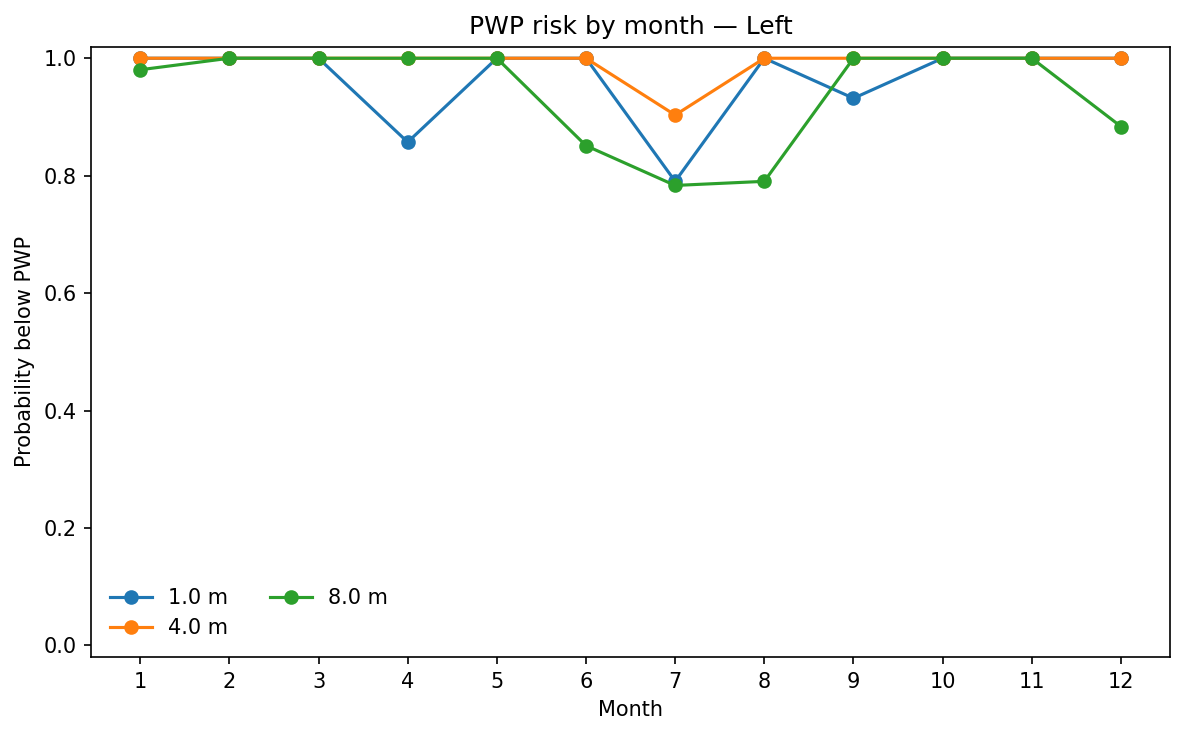

Saved: q3_figs/pwp_monthly_curves_L.png | q3_figs/pwp_monthly_curves_L.pdf


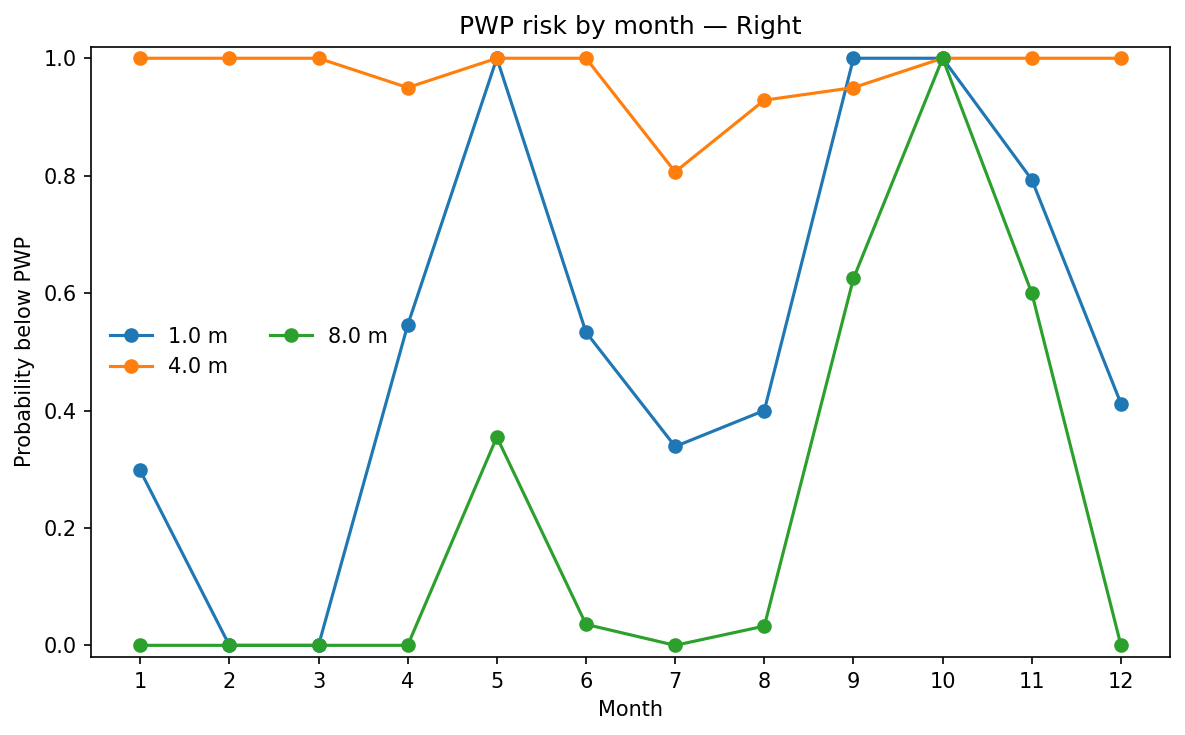

Saved: q3_figs/pwp_monthly_curves_R.png | q3_figs/pwp_monthly_curves_R.pdf


In [8]:
# Monthly risk curves by side & distance (just for an overview line plot)
M = (per_day.assign(month=lambda x: pd.to_datetime(x["_date"]).dt.month)
             .groupby(["month","side","distance_m"], observed=True)["p_below"]
             .mean().reset_index())

for side, color in [("L", COLOR_L), ("R", COLOR_R)]:
    g = M[M["side"]==side]
    plt.figure(figsize=(8,5))
    for dist in [1.0,4.0,8.0,16.5]:
        gg = g[np.isclose(g["distance_m"], dist)]
        if len(gg):
            plt.plot(gg["month"], gg["p_below"], marker="o", label=f"{dist} m")
    plt.ylim(-0.02, 1.02)
    plt.xticks(range(1,13))
    plt.xlabel("Month"); plt.ylabel("Probability below PWP")
    plt.title(f"PWP risk by month — {'Left' if side=='L' else 'Right'}")
    plt.legend(frameon=False, ncol=2)
    plt.tight_layout()
    base = os.path.join(FIG_DIR, f"pwp_monthly_curves_{side}")
    plt.savefig(base+".png", dpi=300); plt.savefig(base+".pdf"); plt.show()
    print("Saved:", base+".png", "|", base+".pdf")


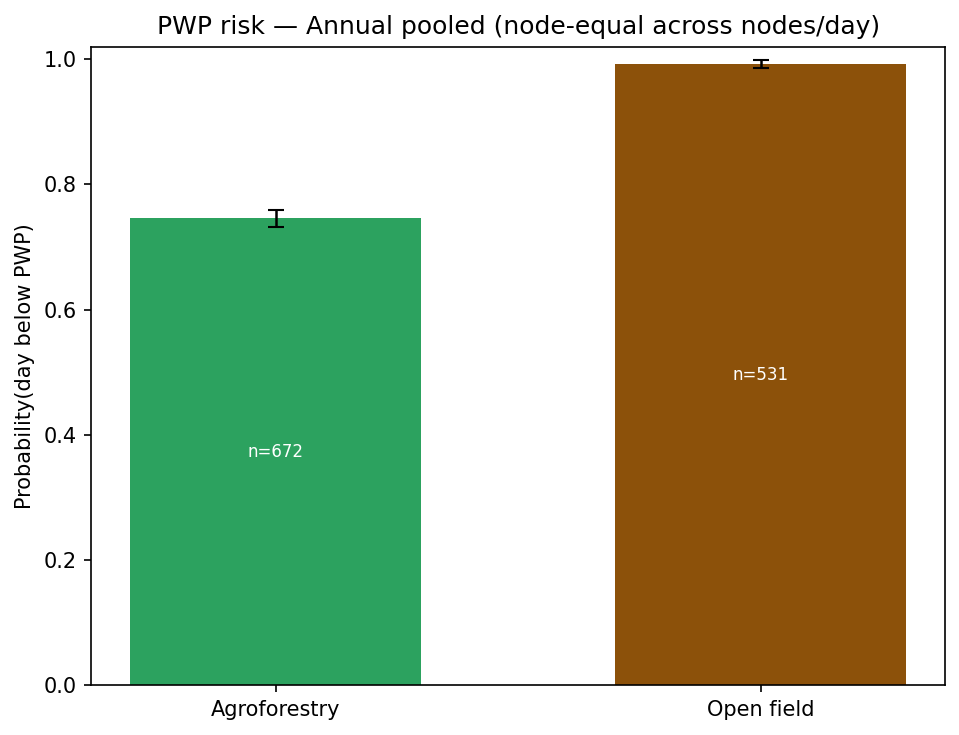

[saved] q3_figs/af_vs_open/pwp_annual_AF_vs_OPEN.png | q3_figs/af_vs_open/pwp_annual_AF_vs_OPEN.pdf


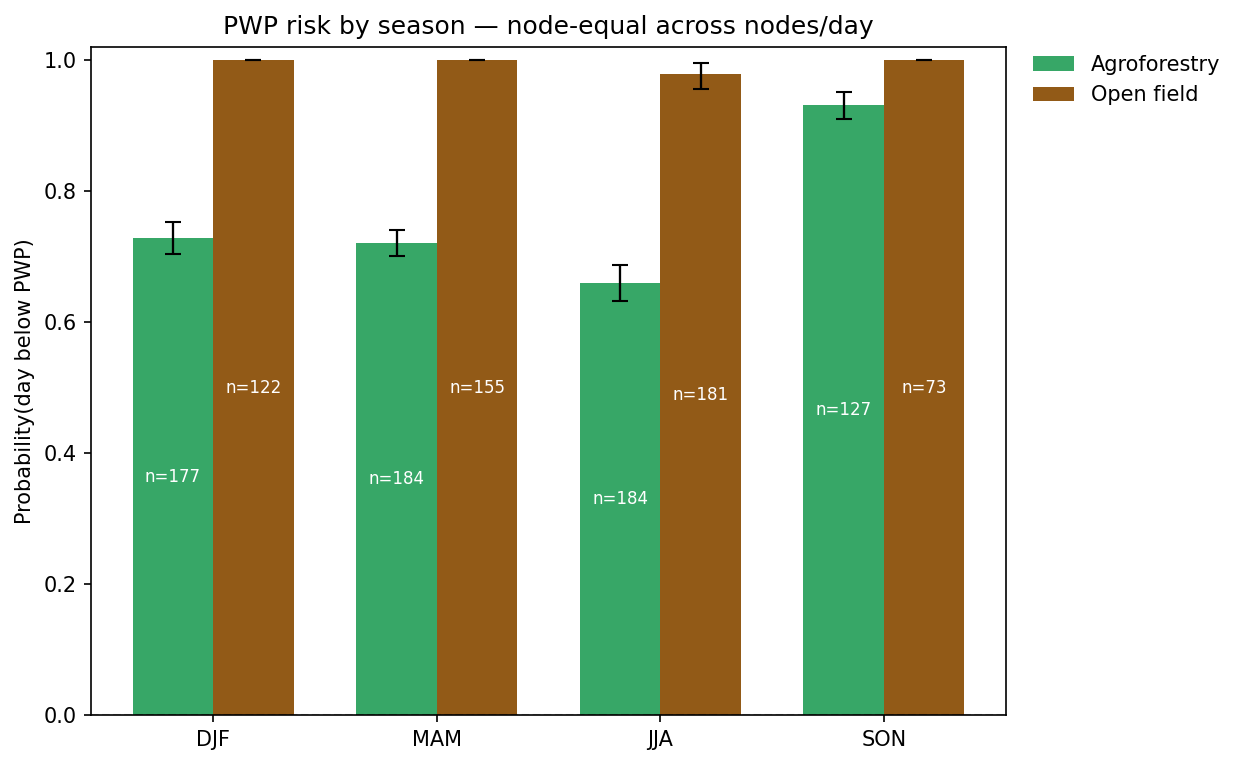

[saved] q3_figs/af_vs_open/pwp_seasonal_AF_vs_OPEN.png | q3_figs/af_vs_open/pwp_seasonal_AF_vs_OPEN.pdf


In [11]:
# ===== AF vs OPEN: PWP risk — annual pooled first, then seasons =====
import os, glob, numpy as np, pandas as pd, matplotlib.pyplot as plt

AFOPEN_FIG_DIR = os.path.join("q3_figs", "af_vs_open")
os.makedirs(AFOPEN_FIG_DIR, exist_ok=True)
os.makedirs("q3_pwp", exist_ok=True)

# --- Colors & small annotation font ---
COLOR_AF   = "#2ca25f"  # green
COLOR_OPEN = "#8c510a"  # brown
FS_ANN     = 8

def _bootstrap_mean_ci(vals, B=2000, seed=123, q=(2.5,97.5)):
    v = pd.to_numeric(pd.Series(vals), errors="coerce").to_numpy(float)
    v = v[np.isfinite(v)]
    if v.size == 0: return (np.nan, np.nan, np.nan)
    rng = np.random.default_rng(seed)
    idx = rng.integers(0, v.size, size=(B, v.size))
    m = v[idx].mean(axis=1)
    lo, hi = np.percentile(m, list(q))
    return float(v.mean()), float(lo), float(hi)

# --- Build site_day (node-equal daily, AF vs OPEN) if missing ---
if 'site_day' not in globals():
    # Find CSV
    def _pick_latest(paths):
        paths = [p for p in paths if os.path.isfile(p)]
        return max(paths, key=os.path.getmtime) if paths else None
    pats = ["analysis_ready_v*.csv", "af_clean_v01/analysis_ready_v*.csv", "**/analysis_ready_v*.csv"]
    hits = []
    for pat in pats: hits.extend(glob.glob(pat, recursive=True))
    CSV_PATH = _pick_latest(hits); assert CSV_PATH, "No analysis_ready CSV found."
    df = pd.read_csv(CSV_PATH, low_memory=False)

    # Time columns -> _date (UTC daily)
    def _to_dt_utc(s): return pd.to_datetime(s, errors="coerce", utc=True)
    COL_TS = "timestamp" if "timestamp" in df.columns else ("timestamp_iso" if "timestamp_iso" in df.columns else ("ts_ns" if "ts_ns" in df.columns else None))
    assert COL_TS is not None, "Need timestamp/timestamp_iso/ts_ns."
    if COL_TS == "ts_ns":
        df["_ts"] = pd.to_datetime(df["ts_ns"].astype("int64"), utc=True, errors="coerce")
    else:
        df["_ts"] = _to_dt_utc(df[COL_TS])
    df["_date"] = (df["_ts"].dt.tz_convert("UTC").dt.floor("D")
                   if df["_ts"].dt.tz is not None else pd.to_datetime(df["_ts"]).dt.floor("D"))

    # Site classification AF vs OPEN
    SITE_COL = "station_type" if "station_type" in df.columns else ("site" if "site" in df.columns else None)
    assert SITE_COL, "Need a site/station_type column."
    def _site_class(s):
        s = str(s).lower()
        if "agro" in s: return "AF"
        if "open" in s: return "OPEN"
        return np.nan
    df["site_class"] = df[SITE_COL].apply(_site_class)
    df = df[df["site_class"].isin(["AF","OPEN"])].copy()

    # Soil moisture composite for PWP
    def choose_first(*cols):
        for c in cols:
            if c in df.columns: return c
        return None
    m0 = choose_first("ground_humidity_0__pref","ground_humidity_0_clean","ground_humidity_0")
    m1 = choose_first("ground_humidity_1__pref","ground_humidity_1_clean","ground_humidity_1")
    assert (m0 is not None) or (m1 is not None), "No soil moisture columns found."

    def _rowmean(frame, cols):
        cols = [c for c in cols if c and c in frame.columns]
        if not cols: return np.full(len(frame), np.nan)
        arr = np.vstack([pd.to_numeric(frame[c], errors="coerce").to_numpy() for c in cols])
        return np.nanmean(arr, axis=0)
    df["soil_moisture__comp"] = _rowmean(df, [m0, m1])

    # PWP config (use your existing globals if set)
    if 'PWP' not in globals(): PWP = 10.0
    if 'PWP_BY_NODE' not in globals(): PWP_BY_NODE = {}
    NODE_COL = "node" if "node" in df.columns else ("node_id" if "node_id" in df.columns else None)
    assert NODE_COL, "Need node/node_id column."
    if "node" not in df.columns and "node_id" in df.columns:
        df.rename(columns={"node_id":"node"}, inplace=True)
    df["node_key"] = df["node"].astype(str)
    df["node_key"] = np.where(df["node_key"].str.startswith("node_"), df["node_key"], "node_"+df["node_key"])

    def _thr(node_key): return float(PWP_BY_NODE.get(node_key, PWP))

    # Node-equal daily risk per site
    work = df[["_date","site_class","node_key","soil_moisture__comp"]].copy()
    work["soil_moisture__comp"] = pd.to_numeric(work["soil_moisture__comp"], errors="coerce")

    daily_node = (work.groupby(["_date","site_class","node_key"], observed=True, as_index=False)
                       .mean(numeric_only=True))
    daily_node["pwp_thresh"] = daily_node["node_key"].map(_thr).astype(float)
    daily_node["below_pwp"]  = (daily_node["soil_moisture__comp"] < daily_node["pwp_thresh"]).astype(float)

    site_day = (daily_node.groupby(["_date","site_class"], observed=True)
                          .agg(p_below=("below_pwp","mean"),
                               n_nodes=("below_pwp","count"))
                          .reset_index()
                          .sort_values(["_date","site_class"]))
    site_day.to_csv("q3_pwp/af_open_risk_by_day.csv", index=False)

# Derive season labels
site_day = site_day.copy()
site_day["month"]  = pd.to_datetime(site_day["_date"]).dt.month
site_day["season"] = site_day["month"].map({12:"DJF",1:"DJF",2:"DJF",
                                            3:"MAM",4:"MAM",5:"MAM",
                                            6:"JJA",7:"JJA",8:"JJA",
                                            9:"SON",10:"SON",11:"SON"})

# =========================
# 1) Annual pooled (clean)
# =========================
summ_annual = []
for site in ["AF","OPEN"]:
    v = site_day.loc[site_day["site_class"]==site, "p_below"]
    mu, lo, hi = _bootstrap_mean_ci(v, B=2000, seed=123)
    summ_annual.append({"site_class":site, "mean":mu, "lo":lo, "hi":hi, "n_days":int(v.size)})
ann = pd.DataFrame(summ_annual)

plt.figure(figsize=(6.5,5))
xs = np.arange(2)
means = ann["mean"].values
los   = ann["lo"].values
his   = ann["hi"].values
ns    = ann["n_days"].values
colors = [COLOR_AF, COLOR_OPEN]
labels = ["Agroforestry","Open field"]

for i in range(2):
    plt.bar(xs[i], means[i], color=colors[i], width=0.6)
    plt.errorbar(xs[i], means[i],
                 yerr=[[means[i]-los[i]],[his[i]-means[i]]],
                 fmt="none", ecolor="black", lw=1.2, capsize=4)
    # number inside bar, centered
    y_txt = 0.5*means[i] if np.isfinite(means[i]) else 0.05
    txt_col = "white" if means[i] > 0.15 else "black"
    plt.text(xs[i], y_txt, f"n={ns[i]}", ha="center", va="center",
             fontsize=FS_ANN, color=txt_col)

plt.xticks(xs, labels)
plt.ylim(0, 1.02)
plt.ylabel("Probability(day below PWP)")
plt.title("PWP risk — Annual pooled (node-equal across nodes/day)")
plt.tight_layout()
base = os.path.join(AFOPEN_FIG_DIR, "pwp_annual_AF_vs_OPEN")
plt.savefig(base+".png", dpi=300); plt.savefig(base+".pdf"); plt.show()
print("[saved]", base+".png", "|", base+".pdf")

# =========================
# 2) Seasonal bars (clean)
# =========================
SEAS = ["DJF","MAM","JJA","SON"]
width = 0.36
xs = np.arange(len(SEAS))

plt.figure(figsize=(8.4,5.2))
for site, color, off, leg in [("AF", COLOR_AF, -width/2, "Agroforestry"),
                              ("OPEN", COLOR_OPEN,  width/2, "Open field")]:
    means, los, his, ns = [], [], [], []
    for s in SEAS:
        days = site_day[(site_day["season"]==s) & (site_day["site_class"]==site)]["p_below"]
        mu, lo, hi = _bootstrap_mean_ci(days, B=2000, seed=123)
        means.append(mu); los.append(lo); his.append(hi); ns.append(int(days.size))
    pos = xs + off
    plt.bar(pos, means, width=width, color=color, alpha=0.95, label=leg)
    # CIs + numbers inside bars (centered)
    for j, x in enumerate(pos):
        if np.isfinite(means[j]):
            plt.errorbar(x, means[j], yerr=[[means[j]-los[j]],[his[j]-means[j]]],
                         fmt="none", ecolor="black", lw=1.1, capsize=4)
            y_txt = 0.5*means[j] if means[j] > 0 else 0.05
            txt_col = "white" if means[j] > 0.15 else "black"
            plt.text(x, y_txt, f"n={ns[j]}", ha="center", va="center",
                     fontsize=FS_ANN, color=txt_col)

plt.axhline(0, color="k", lw=1, ls="--", alpha=0.25)
plt.xticks(xs, SEAS); plt.ylim(0, 1.02)
plt.ylabel("Probability(day below PWP)")
plt.title("PWP risk by season — node-equal across nodes/day")
# Legend outside, upper-right of the axes
plt.legend(frameon=False, bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.0)
plt.tight_layout()
base = os.path.join(AFOPEN_FIG_DIR, "pwp_seasonal_AF_vs_OPEN")
plt.savefig(base+".png", dpi=300, bbox_inches="tight"); plt.savefig(base+".pdf", bbox_inches="tight"); plt.show()
print("[saved]", base+".png", "|", base+".pdf")
